In [1]:
import torch
from torch.utils import data
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from unet import UNet
from diffusion import GaussianDiffusion, Trainer

## Dataloader

In [2]:
class Dataset(data.Dataset):
    def __init__(self, folder, image_size, mode):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.mode = mode

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ])
        
    def __len__(self):
        dir_path = self.folder+"data/"
        res = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
        return res

    def irregular_mask(self, data, rate=0.5):
        """the mask matrix of random sampling
        Args:
            data: original data patches
            rate: sampling rate,range(0,1)
        """
        n = data.size()[-1]
        mask = torch.torch.zeros(data.size(),dtype=torch.float64)
        v = round(n*rate)
        TM = random.sample(range(n),v)
        mask[:,:,TM]=1 # missing by column 
        mask = mask.type(torch.FloatTensor)
        return  mask

    def __getitem__(self, index):

        data = self.folder+"data/"+str(index)+".png"
        img_data = Image.open(data)

        if self.mode == "demultiple":
            label = self.folder+"labels/"+str(index)+".png"
            img_label = Image.open(label)
            return self.transform(img_data), self.transform(img_label)
        elif self.mode == "interpolation":
            return self.irregular_mask(self.transform(img_data)), self.transform(img_data)
        elif self.mode == "denoising":
            img = self.transform(img_data)
            mean = torch.mean(img)
            std = torch.std(img)
            noise = 0.5*torch.normal(mean, std, size =(img.shape[0], img.shape[1], img.shape[2]))
            img_ = img + noise
            return img_, img  
        else:
            print("ERROR MODE DATASET")

## Create Model

In [3]:
mode = "demultiple" #demultiple, interpolation, denoising
folder = './dataset/'+mode+'/data_train/'

image_size = (64,128)
    
model = UNet(
        in_channel=2,
        out_channel=1
).cuda()

diffusion = GaussianDiffusion(
    model,
    mode = mode,
    channels = 1,
    image_size = image_size,
    timesteps = 2000,
    loss_type = 'l1', # L1 or L2
).cuda()

ds = Dataset(folder, image_size=image_size, mode=mode)

## Load Model

In [4]:
parameters = torch.load("model_test.pt")['model']

del parameters['betas']
del parameters['alphas_cumprod']
del parameters['alphas_cumprod_prev']
del parameters['sqrt_alphas_cumprod']
del parameters['sqrt_one_minus_alphas_cumprod']
del parameters['log_one_minus_alphas_cumprod']
del parameters['sqrt_recip_alphas_cumprod']
del parameters['sqrt_recipm1_alphas_cumprod']
del parameters['posterior_variance']
del parameters['posterior_log_variance_clipped']
del parameters['posterior_mean_coef1']
del parameters['posterior_mean_coef2']


def change_key(self, old, new):
    #copy = self.copy()
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v
        
keys = []
for key, value in parameters.items():
    keys.append(key)
    
for i in range(len(keys)):
    change_key(parameters, keys[i], keys[i][11:])
    
model.load_state_dict(parameters)

<All keys matched successfully>

In [5]:
import types
import torch
from tqdm import tqdm

def p_sample_loop_with_intermediates(self, x_in, mask=None, save_every=500):
    device = self.betas.device
    b, c, h, w = x_in.shape

    # condition
    if mask is None:
        x_cond = x_in
    else:
        x_cond = x_in * mask

    # start from pure noise
    img = torch.randn((b, c, h, w), device=device)

    intermediates = []
    intermediates.append((self.num_timesteps, img.detach().cpu()))  # initial noise (optional)

    for i in tqdm(reversed(range(0, self.num_timesteps)),
                  desc='sampling loop time step',
                  total=self.num_timesteps):
        img = self.p_sample(img, i, condition_x=x_cond)

        if mask is not None:
            # keep known region fixed
            img = x_cond + img * (1. - mask)

        #if (i % save_every == 0) or (i == 0):
        #    intermediates.append((int(i), img.detach().cpu()))
        if (i > 300 and i % 500 == 0) or (i <= 300 and i % 25 == 0) or (i == 0):
            intermediates.append((int(i), img.detach().cpu()))

    # keep the same output structure as original implementation
    if mask is None:
        ret_img = torch.cat([x_cond, img], dim=0)
    else:
        ret_img = torch.cat([x_cond, x_in, img], dim=0)

    return ret_img, intermediates

# patch ONLY this notebook runtime (does not modify diffusion.py file)
diffusion.p_sample_loop = types.MethodType(p_sample_loop_with_intermediates, diffusion)


In [6]:
num = 1
in_samples = np.zeros([num,image_size[0],image_size[1]])
out_samples = np.zeros([num,image_size[0],image_size[1]])

inter_first = None  # save intermediates of the first sample only

for i, (x_in) in enumerate(ds):

    x_start = x_in[0]
    x_start = torch.unsqueeze(x_start, dim=0)

    x_ = x_in[1]
    x_ = torch.unsqueeze(x_, dim=0)

    if mode == "interpolation":
        out, inter = diffusion.p_sample_loop(x_.cuda(), mask=x_start.cuda(), save_every=500)
    else:
        out, inter = diffusion.p_sample_loop(x_start.cuda(), mask=None, save_every=500)

    if i == 0:
        inter_first = inter

    in_samples[i] = out[0,0].cpu().detach().numpy()
    out_samples[i] = out[1,0].cpu().detach().numpy()
    if mode == "interpolation":
        out_samples[i] = out[2,0].cpu().detach().numpy()

    if i == num-1:
        break


sampling loop time step: 100%|██████████████████████████| 2000/2000 [00:36<00:00, 55.47it/s]


## Intermediate sampling frames (every 500 steps)


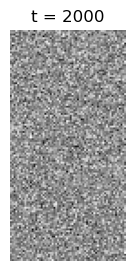

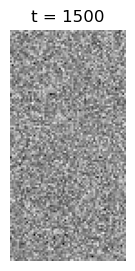

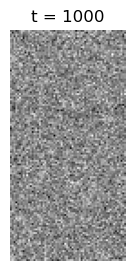

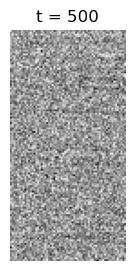

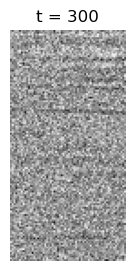

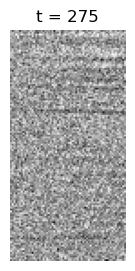

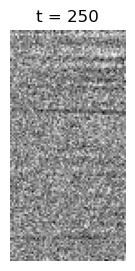

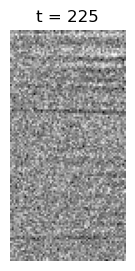

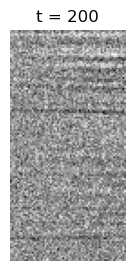

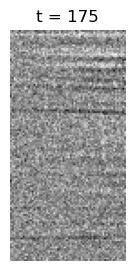

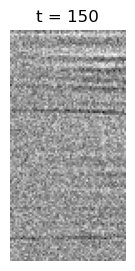

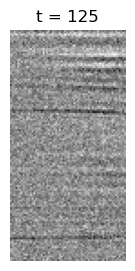

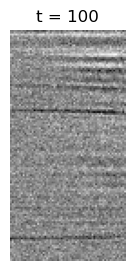

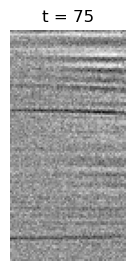

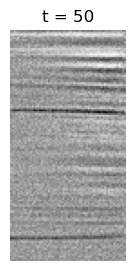

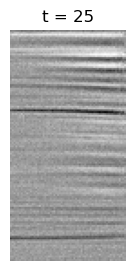

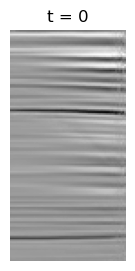

In [7]:
# Plot intermediate frames for the first sample
# inter_first is a list of (t, tensor_cpu[B,C,H,W])

import matplotlib.pyplot as plt

# Use final frame to set consistent color limits
vmin = inter_first[-1][1][0,0].min().item()
vmax = inter_first[-1][1][0,0].max().item()

for t, ten in inter_first:
    img = ten[0,0].numpy()
    plt.figure(figsize=(6,3))
    plt.title(f"t = {t}")
    #plt.imshow(img.T, cmap="Greys", vmin=vmin, vmax=vmax)
    plt.imshow(img.T, cmap="Greys", vmin=img.min(), vmax=img.max())
    plt.axis("off")
    plt.show()


## Plotting

[None, None]

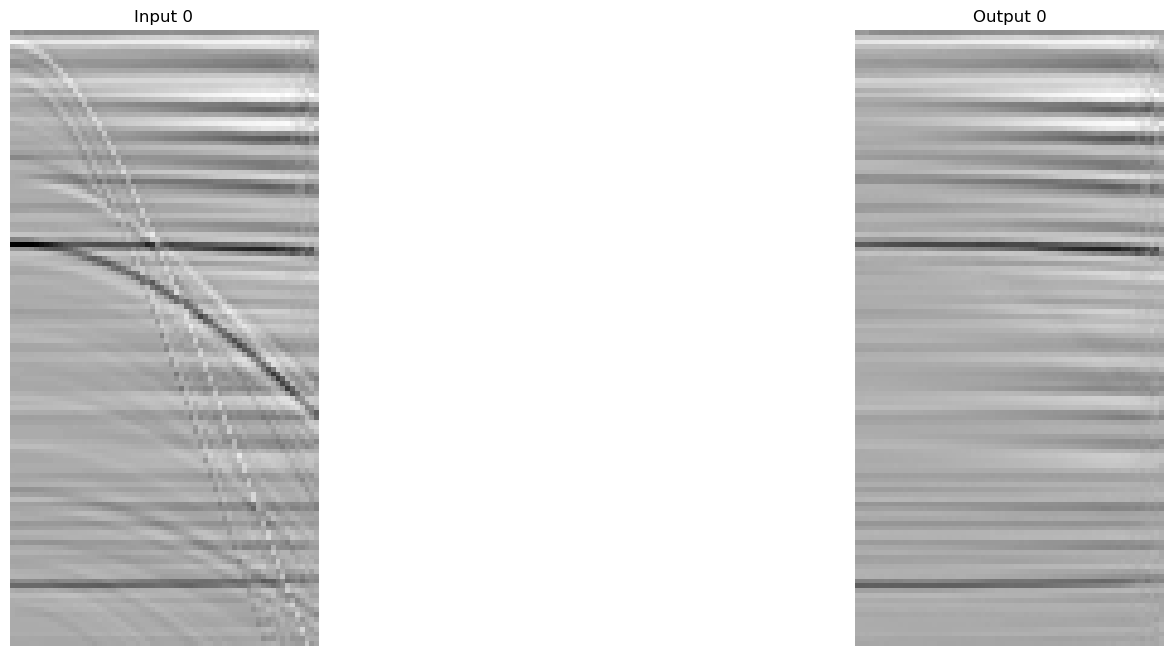

In [8]:
fig, axs = plt.subplots(1,2* num, figsize=(20,8))

max_ = x_start.max()
min_ = x_start.min()
cont = 0
for i in range(num):
    axs[cont].imshow(in_samples[i].T, vmin=min_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(out_samples[i].T, vmin=min_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Output "+str(i))
    cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]